In [1]:
# --- 2. Imports ---
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

# If your code is in a local directory, you might need to add it to sys.path:
# (Adjust the path to where your environment code or models are located)
# sys.path.append("/path/to/your/project")

# Example: from your module that implements HockeyEnv_BasicOpponent
from hockey.hockey_env import HockeyEnv_BasicOpponent, Mode


# Import your DDPG modules (Agent/Trainer) from your project structure
try:
    from models.ddpg.DDPG import DDPGAgent
    from models.ddpg.DDPGTrainer import DDPGTrainer
except ImportError:
    print("Could not import your DDPG modules. Adjust your paths accordingly.")
    raise

In [2]:
# --- 3. Initialize the Environment & Check Spaces ---

# The single-agent wrapper environment is `HockeyEnv_BasicOpponent`.
# By default:
#   - It uses mode=Mode.NORMAL
#   - keep_mode=True
#   - An opponent with `weak_opponent=False` or True
#
# This environment has an action_space of shape (4,) 
# suitable for a single-agent continuous control algorithm like DDPG.

env = HockeyEnv_BasicOpponent(
    mode=Mode.NORMAL,   # or Mode.TRAIN_SHOOTING, Mode.TRAIN_DEFENSE
    weak_opponent=True # whether the opponent is weaker or not
)

print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

# For reference:
# - The observation space is Box(...) with shape (18,) if keep_mode=True.
# - The action space is Box(...) with shape (4,). 
#   The four actions: 
#       1) Force in x, 
#       2) Force in y, 
#       3) Torque (racket rotation),
#       4) Shoot command (0 or 1).

Observation space: Box(-inf, inf, (18,), float32)
Action space: Box(-1.0, 1.0, (4,), float32)


In [3]:
# --- 4. Instantiate the Trainer ---

# The DDPGTrainer expects:
#  - environment name
#  - training_config (like #episodes, #timesteps, etc.)
#  - model_config (DDPG hyperparameters)
#  - experiment_path (where logs/stats are saved)

training_config = {
    "epsilon_start": 1.0,   # Initial exploration rate
    "epsilon_min": 0.05,  # Final exploration rate
    "epsilon_decay": 0.999,  # Decay rate
    "max_episodes": 20000,     
    "max_timesteps": 250,    # the environment uses ~250 for normal mode
    "log_interval": 20,
    "save_interval": 1000,
    "render": False,         
    "train_iter": 32,        # How many DDPG updates each episode
    "seed": 42              
}

model_config = {
    "eps": 0.0,                  # Noise scale
    "discount": 0.95,      
    "buffer_size": int(1e6),     
    "batch_size": 128,            
    "learning_rate_actor": 1e-4, 
    "learning_rate_critic": 1e-3,
    "hidden_sizes_actor": [256, 256],
    "hidden_sizes_critic": [256, 256],
    "update_target_every": 100,
    "use_target_net": True
}

experiment_path = "rl_experiments/experiments/HockeyEnv_DDPG_Test"

# Initialize trainer
trainer = DDPGTrainer(
    env_name="HockeyEnv",
    training_config=training_config,
    model_config=model_config,
    experiment_path=experiment_path,
    wandb_run=None  # or a Weights & Biases run object if you use wandb
)

# # Overwrite the default environment in trainer with our custom env:
# trainer.env = env


2025-01-25 23:07:41 [INFO] Logger initialized. Writing logs to rl_experiments/experiments/HockeyEnv_DDPG_Test/results/training/logs/DDPG_HockeyEnv_eps0.0_alr0.0001_clr0.001_gamma0.95.log
2025-01-25 23:07:41 [INFO] Initialized random seeds to 42.


In [4]:
# --- 5. training the agent ---

final_metrics = trainer.train()

print("Training finished.")
print("Final metrics:", final_metrics)


2025-01-22 23:53:07 [INFO] Starting DDPG Training...
2025-01-22 23:53:07 [INFO] Environment: HockeyEnv, max_episodes=2000, max_timesteps=250, train_iter=32
2025-01-22 23:53:09 [INFO] Episode 10	Avg Length: 193.00	Avg Reward: -24.260
2025-01-22 23:53:10 [INFO] Episode 20	Avg Length: 162.30	Avg Reward: -28.068
2025-01-22 23:53:11 [INFO] Episode 30	Avg Length: 145.10	Avg Reward: -20.945
2025-01-22 23:53:12 [INFO] Episode 40	Avg Length: 170.50	Avg Reward: -26.474
2025-01-22 23:53:13 [INFO] Episode 50	Avg Length: 173.10	Avg Reward: -22.535
2025-01-22 23:53:14 [INFO] Episode 60	Avg Length: 169.60	Avg Reward: -24.839
2025-01-22 23:53:15 [INFO] Episode 70	Avg Length: 184.20	Avg Reward: -20.180
2025-01-22 23:53:17 [INFO] Episode 80	Avg Length: 167.70	Avg Reward: -26.981
2025-01-22 23:53:18 [INFO] Episode 90	Avg Length: 211.20	Avg Reward: -23.640
2025-01-22 23:53:19 [INFO] Saved checkpoint at episode 100 -> rl_experiments/experiments/HockeyEnv_DDPG_Test/results/training/saved_models/DDPG_HockeyE

In [11]:
import torch

checkpoint_path = "DDPG_HockeyEnv_eps0_alr0.0001_clr0.001_gamma0.99_checkpoint_ep6000.pth"

checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))

# 4) Restore the agent's networks
trainer.agent.restore_state(checkpoint)

/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_11432/1178676890.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_

In [9]:
# --- 6. Testing ---

num_test_episodes = 100
cumulative_rewards = []
win_count = 0
for ep in range(num_test_episodes):
    obs, _ = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # set simple deterministic policy
        action = trainer.agent.act(obs, evaluate=True)  
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        env.render(mode="rgb_array")

        if done or trunc:
            break
    cumulative_rewards.append(episode_reward)
    win_count += info["winner"] 

env.close()

print("Average cumulative reward:", np.mean(cumulative_rewards))
print("Win rate:", win_count / num_test_episodes)



Average cumulative reward: 1.7697093521576663
Win rate: 0.31


In [6]:
# plot the cumulative rewards
plt.plot(cumulative_rewards)
plt.xlabel("Episode")
plt.ylabel("Cumulative Reward")
plt.title("Cumulative Rewards over Episodes")
plt.show()


/var/folders/x2/dvcm78hn67g79fdt399dzt8c0000gn/T/ipykernel_11432/4163330427.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [12]:
import imageio
import numpy as np

num_test_episodes = 50

for ep in range(num_test_episodes):
    frames = []
    obs, info = env.reset()
    done = False
    episode_reward = 0.0
    while not done:
        # Act with no noise at test time
        action = trainer.agent.act(obs, evaluate=True)
        obs, reward, done, trunc, info = env.step(action)
        episode_reward += reward

        # ---- Capture frame in rgb_array mode ----
        frame_rgb = env.render(mode='rgb_array')  
        frames.append(frame_rgb)

        if done or trunc:
            break

    env.close()
    print(f"Episode reward: {episode_reward}")

    # 4) Save frames as GIF
    gif_path = f"gifs/ddpg_laserhockey_episode{ep}.gif"
    imageio.mimsave(gif_path, frames, fps=15)  # set fps as desired
    print(f"Saved GIF to {gif_path}")

Episode reward: -4.250743748349239
Saved GIF to gifs/ddpg_laserhockey_episode0.gif
Episode reward: 8.785197921145162
Saved GIF to gifs/ddpg_laserhockey_episode1.gif
Episode reward: 9.337981342618626
Saved GIF to gifs/ddpg_laserhockey_episode2.gif
Episode reward: 8.07929827439172
Saved GIF to gifs/ddpg_laserhockey_episode3.gif
Episode reward: -11.895041201968144
Saved GIF to gifs/ddpg_laserhockey_episode4.gif
Episode reward: 8.842665549395539
Saved GIF to gifs/ddpg_laserhockey_episode5.gif
Episode reward: 9.50634776967265
Saved GIF to gifs/ddpg_laserhockey_episode6.gif
Episode reward: -2.94832589936637
Saved GIF to gifs/ddpg_laserhockey_episode7.gif
Episode reward: -3.0544151922847758
Saved GIF to gifs/ddpg_laserhockey_episode8.gif
Episode reward: -0.6828182922322791
Saved GIF to gifs/ddpg_laserhockey_episode9.gif
Episode reward: 9.262973091655972
Saved GIF to gifs/ddpg_laserhockey_episode10.gif
Episode reward: -12.031332935443476
Saved GIF to gifs/ddpg_laserhockey_episode11.gif
Episode

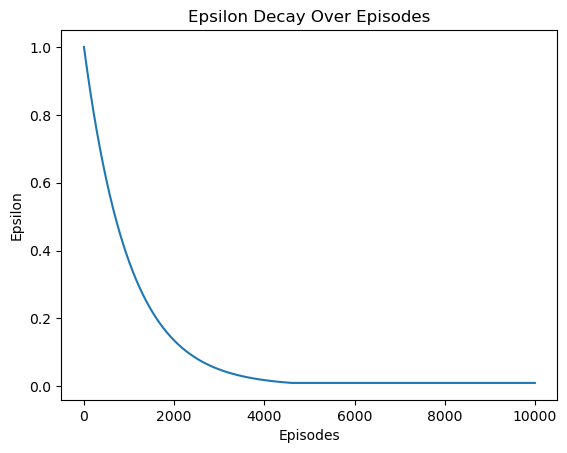

In [23]:
epsilon_start = 1.0  
epsilon_end = 0.01  
epsilon_decay = 0.999
max_episodes=10000
max_steps=500
episodes = np.arange(max_episodes)
epsilon_values = epsilon_start * (epsilon_decay ** episodes)
epsilon_values = np.maximum(epsilon_values, epsilon_end)

plt.plot(episodes, epsilon_values)
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay Over Episodes')
plt.show()

In [12]:

# 4) Save frames as GIF
gif_path = "ddpg_laserhockey_episode.gif"
imageio.mimsave(gif_path, frames, fps=15)  # set fps as desired
print(f"Saved GIF to {gif_path}")

Saved GIF to ddpg_laserhockey_episode.gif
